# DeepAR on laptime&rank dataset

laptime&rank dataset
<eventid, carids, laptime (totalcars x totallaps), rank (totalcars x totallaps)>; filled with NaN

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets


In [2]:
import pickle
with open('laptime_rank-2018.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1')

In [3]:
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
events_id={key:idx for idx, key in enumerate(events)}

In [4]:
print(f"events: {events}")

events: ['Phoenix', 'Indy500', 'Texas', 'Iowa', 'Pocono', 'Gateway']


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

In [5]:
laptime_data[2][2].astype(np.float32)

array([[26.0364, 24.6531, 24.3582, ...,     nan,     nan,     nan],
       [62.1349, 66.7862,     nan, ...,     nan,     nan,     nan],
       [28.33  , 26.3849, 25.3203, ...,     nan,     nan,     nan],
       ...,
       [64.83  , 58.0034,     nan, ...,     nan,     nan,     nan],
       [28.0383, 26.1015, 25.6888, ...,     nan,     nan,     nan],
       [27.296 , 26.2981, 25.0074, ...,     nan,     nan,     nan]],
      dtype=float32)

In [6]:
# global configuration
prediction_length = 50
freq = "1H"
cardinality = [len(global_carids)]
TS_LAPTIME=2
TS_RANK=3
run_ts = TS_RANK

In [7]:
from gluonts.dataset.common import ListDataset
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

train_set = []
test_set = []

#_data: eventid, carids, laptime array
for _data in laptime_data:
    #_train = [{'target': x.astype(np.float32), 'start': start} 
    #        for x in _data[2][:, :-prediction_length]]
    #_test = [{'target': x.astype(np.float32), 'start': start} 
    #        for x in _data[2]]
    
    #map rowid -> carno -> global_carid
    #carids = list(_data[1].values())
    #global_carid = global_carids[_data[1][rowid]]
    
    _train = [{'target': _data[run_ts][rowid, :-prediction_length].astype(np.float32), 'start': start, 
               'feat_static_cat': global_carids[_data[1][rowid]]}             
            for rowid in range(_data[run_ts].shape[0]) ]
    _test = [{'target': _data[run_ts][rowid, :].astype(np.float32), 'start': start, 
              'feat_static_cat': global_carids[_data[1][rowid]]} 
            for rowid in range(_data[run_ts].shape[0]) ]
    
    train_set.extend(_train)
    test_set.extend(_test)



In [8]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(train_set, freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(test_set, freq=freq)

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

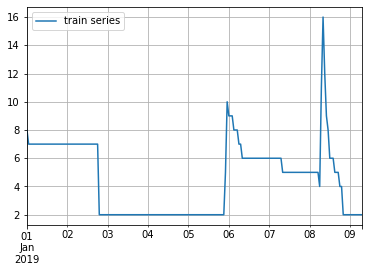

In [9]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

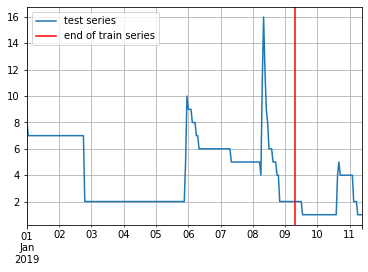

In [10]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [11]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 50
Recommended prediction horizon: 50
Frequency of the time series: 1H


## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [12]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

INFO:root:Using GPU


In [13]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=2*prediction_length,
    use_feat_static_cat=True,
    cardinality=cardinality,
    freq=freq,
    trainer=Trainer(ctx="gpu(2)", 
                    epochs=1, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=64
                   )
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [14]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 64/64 [01:14<00:00,  1.16s/it, avg_epoch_loss=2.16]
INFO:root:Epoch[0] Elapsed time 74.356 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2.156394
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 2.156394312158227 (occurred at epoch 0)
INFO:root:End model training


With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [15]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [16]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [17]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [18]:
# first entry of the time series list
ts_entry = tss[0]

In [19]:
len(ts_entry)

250

In [20]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[-10:]).reshape(-1,)

array([4., 4., 4., 2., 2., 2., 1., 1., 1., 1.], dtype=float32)

In [21]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [22]:
# first 5 values
dataset_test_entry['target'][-10:]

array([4., 4., 4., 2., 2., 2., 1., 1., 1., 1.], dtype=float32)

In [23]:
len(tss[0])

250

In [24]:
forecasts[0].samples.shape

(100, 50)

In [25]:
# Indy500 Car 12 WillPower
ts_entry = tss[52]
ts_entry

,0
2019-01-01 00:00:00,27.0
2019-01-01 01:00:00,24.0
2019-01-01 02:00:00,24.0
2019-01-01 03:00:00,24.0
2019-01-01 04:00:00,24.0
2019-01-01 05:00:00,24.0
2019-01-01 06:00:00,24.0
2019-01-01 07:00:00,24.0
2019-01-01 08:00:00,24.0
2019-01-01 09:00:00,24.0


The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [26]:
# first entry of the forecast list
forecast_entry = forecasts[52]

In [27]:
forecast_entry.samples[0,:]

array([17.19493  , 13.658474 , 13.39533  , 10.613704 , 12.831403 ,
        4.8761053, 10.988232 , 11.907407 , 11.161745 , 12.444239 ,
        9.819384 ,  7.699889 , 10.793732 , 14.398579 , 13.965251 ,
       10.957555 , 11.860864 , 11.479229 , 10.381001 , 15.298147 ,
       14.154023 , 16.812628 , 13.087048 , 13.2998085, 18.92075  ,
       12.182401 , 15.009954 , 14.004843 , 12.641296 , 14.6007395,
       12.984819 , 13.325673 , 13.939358 , 13.460756 , 13.813211 ,
       13.257079 , 12.79001  , 13.224098 , 14.052313 , 13.740417 ,
       13.875024 , 11.582514 , 13.453945 , 16.617495 , 14.4036665,
       12.893073 , 12.468197 , 14.383671 ,  5.8517613,  9.472049 ],
      dtype=float32)

In [28]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 50)
Start date of the forecast window: 2019-01-07 06:00:00
Frequency of the time series: 1H


We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [29]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [13.25134   13.188671  12.301085  11.400879  11.832672  12.465145
 12.130824  11.862519  11.798097  11.7966795 11.655383  11.835288
 11.194057  11.564204  11.163434  11.57277   11.79419   10.546431
 10.285287  11.992748  12.922219  13.083044  12.950461  13.564143
 12.761897  13.416644  13.603898  14.130904  13.810456  13.843468
 13.902042  14.112338  13.990318  14.025995  14.605237  13.500705
 13.995319  14.075117  13.971265  14.419281  13.84233   12.815552
 11.955247  12.6789    12.363072  12.986917  12.894796  12.8935795
 12.291887  12.850544 ]
0.5-quantile (median) of the future window:
 [12.684715  13.19335   12.350619  11.901091  11.881944  11.994469
 12.217533  12.026775  11.967686  11.848625  11.428482  11.84556
 11.271478  11.568616  11.165359  11.662037  11.529533  10.747775
 10.330145  12.259246  12.98476   12.953607  13.178564  13.641705
 13.058712  13.241078  13.757511  13.958941  13.944904  14.022468
 13.821525  13.628307  13.952502  13.804883  

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [30]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

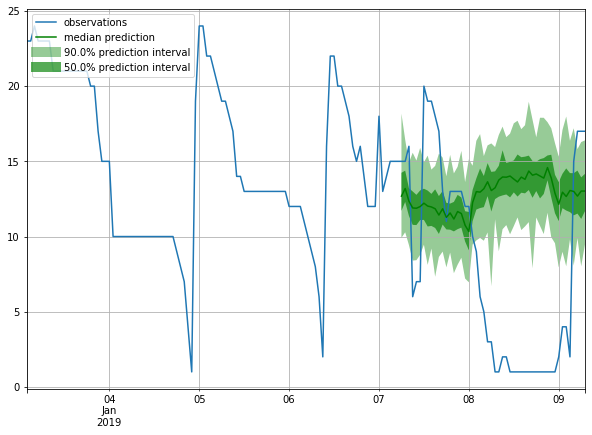

In [31]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [32]:
from gluonts.evaluation import Evaluator

In [33]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 153/153 [00:01<00:00, 129.28it/s]
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:1243: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)


Aggregate metrics aggregate both across time-steps and across time series.

In [34]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 9.011855003984504,
    "abs_error": 11100.156173706055,
    "abs_target_sum": 55147.0,
    "abs_target_mean": 10.214919583363173,
    "seasonal_error": 2.6918673177312615,
    "MASE": 0.9693616692469743,
    "sMAPE": 0.25291619610702537,
    "MSIS": 15.690675444011747,
    "QuantileLoss[0.1]": 6139.718761467934,
    "Coverage[0.1]": 0.17805727972120713,
    "QuantileLoss[0.5]": 11100.156185626984,
    "Coverage[0.5]": 0.49030869745850575,
    "QuantileLoss[0.9]": 6559.673312461377,
    "Coverage[0.9]": 0.7912584535867538,
    "RMSE": 3.0019751837722617,
    "NRMSE": 0.2938814309083271,
    "ND": 0.20128304665178623,
    "wQuantileLoss[0.1]": 0.11133368563054988,
    "wQuantileLoss[0.5]": 0.20128304686795262,
    "wQuantileLoss[0.9]": 0.11894886961142721,
    "mean_wQuantileLoss": 0.1438552007033099,
    "MAE_Coverage": 0.06549670955864918
}


Individual metrics are aggregated only across time-steps.

In [35]:
item_metrics.head()

,Coverage[0.1],Coverage[0.5],Coverage[0.9],MASE,MSE,MSIS,QuantileLoss[0.1],QuantileLoss[0.5],QuantileLoss[0.9],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.76,0.76,1.00,1.028607,5.636545,22.465159,101.713431,104.906215,31.939626,104.906219,1.900000,95.0,NaN,0.822313,2.039773
1,0.00,0.00,1.00,0.511285,1.616421,2.608760,32.628976,45.260334,13.557941,45.260334,19.682927,807.0,NaN,0.057997,2.159091
2,0.38,0.86,0.88,0.533129,2.218419,7.459426,30.220699,61.643056,29.569938,61.643055,3.780000,189.0,NaN,0.328274,2.312500
3,0.64,0.96,1.00,0.918114,3.732843,16.384093,63.971389,84.247355,27.277121,84.247353,2.360000,118.0,NaN,0.593568,1.835227
4,1.00,1.00,1.00,1.833147,14.934911,37.687770,171.076288,193.730336,55.251762,193.730347,4.900000,245.0,NaN,0.568466,2.113636


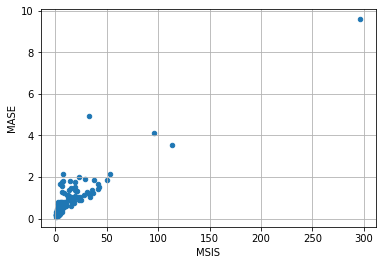

In [36]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

In [37]:
pd.__version__

'0.24.1'

In [38]:
forecast_entry

gluonts.model.forecast.SampleForecast(freq="1H", info=None, item_id=None, samples=numpy.array([[17.194929122924805, 13.65847396850586, 13.395330429077148, 10.613703727722168, 12.831402778625488, 4.876105308532715, 10.988231658935547, 11.9074068069458, 11.161745071411133, 12.444238662719727, 9.81938362121582, 7.699889183044434, 10.793731689453125, 14.398578643798828, 13.965250968933105, 10.957554817199707, 11.86086368560791, 11.479228973388672, 10.381001472473145, 15.298147201538086, 14.154023170471191, 16.8126277923584, 13.087047576904297, 13.299808502197266, 18.92074966430664, 12.182400703430176, 15.009954452514648, 14.004842758178711, 12.64129638671875, 14.600739479064941, 12.984819412231445, 13.32567310333252, 13.93935775756836, 13.460756301879883, 13.813211441040039, 13.257079124450684, 12.790010452270508, 13.224098205566406, 14.052312850952148, 13.740416526794434, 13.87502384185791, 11.582513809204102, 13.45394515991211, 16.617494583129883, 14.403666496276855, 12.893073081970215, 